In [7]:
import torch
import numpy as np

from datasets.dataset import transform_dataset, kfold_dataset
from R2Ntab import train as train_r2ntab, R2Ntab
from DRNet import train as train_drnet, DRNet

import sys

import matplotlib.pyplot as plt

In [2]:
# Read datasets
name = 'house'
X, Y, X_headers, Y_headers = transform_dataset(name, method='onehot-compare', negations=False, labels='binary')
datasets = kfold_dataset(X, Y, shuffle=1)
X_train, X_test, Y_train, Y_test = datasets[0]
train_set = torch.utils.data.TensorDataset(torch.Tensor(X_train.to_numpy()), torch.Tensor(Y_train))
test_set = torch.utils.data.TensorDataset(torch.Tensor(X_test.to_numpy()), torch.Tensor(Y_test))

In [3]:
# Train R2N-tab
# Default learning rate (1e-2), and_lam (1e-2), and and_lam (1e-5) usually work the best. A large epochs number is necessary for a sparse rule set i.e 10000 epochs.
net = R2Ntab(train_set[:][0].size(1), 50, 1)
acc, rules = train_r2ntab(net, train_set, test_set=test_set, device='cpu', lr_rules=1e-2, lr_cancel=5e-3, epochs=1000, batch_size=400,
      and_lam=1e-2, or_lam=1e-5, cancel_lam=1e-10, num_alter=500, track_performance=True)

Epoch: 100%|██████████| 1000/1000 [08:35<00:00,  1.94it/s, rules cancelled=132, loss=0.723, epoch accu=0.506, test accu=0.296, num rules=0, sparsity=nan] 


In [4]:
# Get accuracy and the rule net
accu = (net.predict(np.array(X_test)) == Y_test).mean()
rules = net.get_rules(X_headers)
print(f'Accuracy: {accu}, num rules: {len(rules)}, num conditions: {sum(map(len, rules))}')

Accuracy: 0.2960280886548168, num rules: 0, num conditions: 0


In [5]:
print(rules)

[]


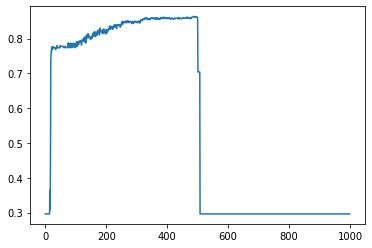

In [8]:
plt.plot(acc)
plt.xlabel("test accuracy")
plt.show()